<font size = '7'>**Setting up environment**

In [1]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 24.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00


In [3]:
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/BT5153/Final Project/Augmented'
    print(path_to_file)
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5153/Final Project/Augmented
/content/gdrive/My Drive/BT5153/Final Project/Augmented


In [4]:
#!unzip "/content/gdrive/My Drive/BT5153/Final Project/Labeled MRI Brain Tumor Dataset.zip" -d "/content/gdrive/My Drive/BT5153/Final Project"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import random
import cv2

import logging
import tempfile
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.transforms.functional as TF
from torch.utils.data._utils.collate import default_collate
from pytorch_lightning import LightningModule, Trainer, LightningDataModule
from torch.optim.lr_scheduler import ExponentialLR, _LRScheduler

In [6]:
import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.config import DtypeLike
from monai.transforms import (
    Lambda,
    EnsureChannelFirst,
    ToTensor,
    Resize,
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    RandRotate,
    RandAffine,
    RandFlip,
    Rand2DElastic
)
from monai.visualize import plot_2d_or_3d_image
from monai.networks.nets import UNet
from monai.networks.nets import DynUNet
from monai.networks.nets import DenseNet121

In [7]:
from lightning.pytorch import seed_everything
seed_everything(55, workers=True)

INFO: Seed set to 55
INFO:lightning.fabric.utilities.seed:Seed set to 55


55

<font size = '7'>**Sampling Data**

(640, 640, 3)


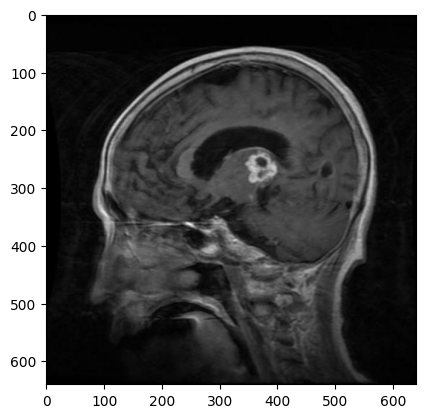

In [8]:
sample_img = img.imread('/content/gdrive/My Drive/BT5153/Final Project/Augmented/train/images/Tr-gl_0025_jpg.rf.bfaffef7138e48c8087da76611cfc1bc.jpg')
print(sample_img.shape)
plt.imshow(sample_img)
plt.show()

In [9]:
# check image shapes for train, valid, test
def collect_unique_shapes(folder_path):
    unique_shapes = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                file_path = os.path.join(root, file)
                image = img.imread(file_path)
                unique_shapes.add(image.shape)
    return unique_shapes

train_folder = "/content/gdrive/My Drive/BT5153/Final Project/Augmented/train/images"
test_folder = "/content/gdrive/My Drive/BT5153/Final Project/Augmented/test/images"
valid_folder = "/content/gdrive/My Drive/BT5153/Final Project/Augmented/valid/images"

train_unique_shapes = collect_unique_shapes(train_folder)
test_unique_shapes = collect_unique_shapes(test_folder)
valid_unique_shapes = collect_unique_shapes(valid_folder)

print("Unique image shapes for train folder:")
print(train_unique_shapes)
print("\nUnique image shapes for test folder:")
print(test_unique_shapes)
print("\nUnique image shapes for valid folder:")
print(valid_unique_shapes)


Unique image shapes for train folder:
{(640, 640, 3)}

Unique image shapes for test folder:
{(640, 640, 3)}

Unique image shapes for valid folder:
{(640, 640, 3)}


Label counts for train folder:
{'1': 718, '2': 670, '3': 880, '0': 1166}


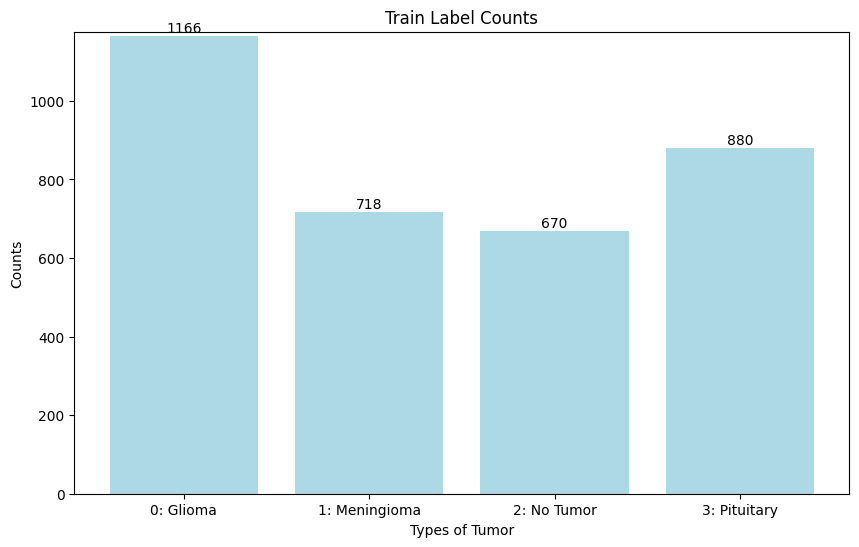


Label counts for test folder:
{'1': 63, '2': 49, '3': 54, '0': 84}


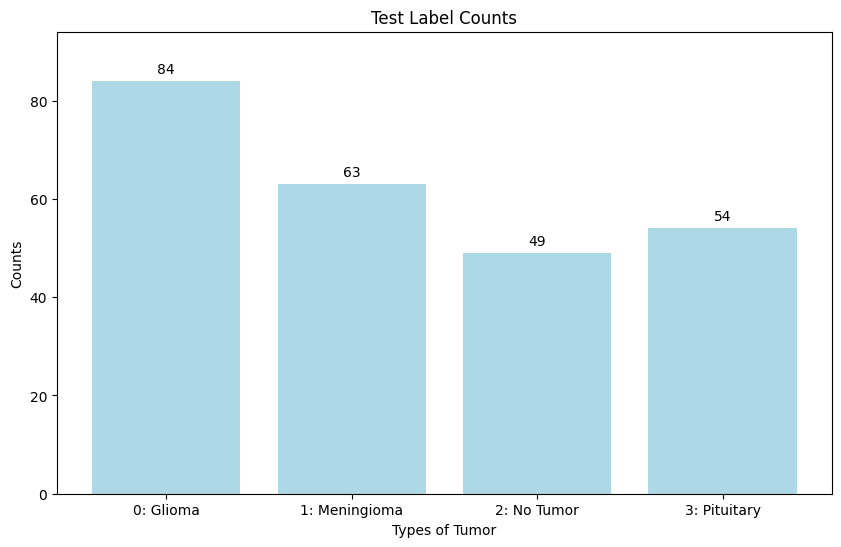


Label counts for valid folder:
{'1': 250, '2': 198, '3': 236, '0': 326}


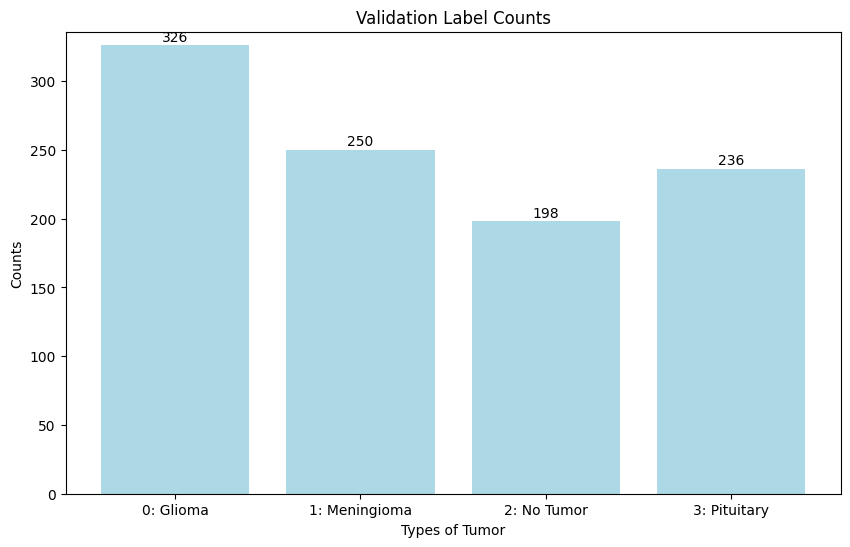

In [10]:
# check count of labels where 1: pituitary, 2: meningioma, 3:glioma, 0:no tumor

def count_labels(folder_path):
    label_counts = {'1': 0, '2': 0, '3': 0, '0': 0}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        first_number = line.split()[0]
                        if first_number in label_counts:
                            label_counts[first_number] += 1
    return label_counts

train_labels_folder = "/content/gdrive/My Drive/BT5153/Final Project/Augmented/train/labels"
test_labels_folder = "/content/gdrive/My Drive/BT5153/Final Project/Augmented/test/labels"
valid_labels_folder = "/content/gdrive/My Drive/BT5153/Final Project/Augmented/valid/labels"

train_label_counts = count_labels(train_labels_folder)
test_label_counts = count_labels(test_labels_folder)
valid_label_counts = count_labels(valid_labels_folder)

train_counts = [train_label_counts['0'], train_label_counts['1'], train_label_counts['2'], train_label_counts['3']]
test_counts = [test_label_counts['0'], test_label_counts['1'], test_label_counts['2'], test_label_counts['3']]
valid_counts = [valid_label_counts['0'], valid_label_counts['1'], valid_label_counts['2'], valid_label_counts['3']]

count_labels = ['0: Glioma', '1: Meningioma', '2: No Tumor', '3: Pituitary']


x = range(len(count_labels))  # the label locations for each bar group


# barplot for train
print("Label counts for train folder:")
print(train_label_counts)

plt.figure(figsize=(10, 6))
bars_train = plt.bar(x, train_counts, color=['lightblue'])
plt.xlabel('Types of Tumor')
plt.ylabel('Counts')
plt.title('Train Label Counts')
plt.xticks(x, count_labels)
plt.ylim(0, max(train_counts) + 10)
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.show()

# barplot for test
print("\nLabel counts for test folder:")
print(test_label_counts)

plt.figure(figsize=(10, 6))
bars_test = plt.bar(x, test_counts, color=['lightblue'])
plt.xlabel('Types of Tumor')
plt.ylabel('Counts')
plt.title('Test Label Counts')
plt.xticks(x, count_labels)
plt.ylim(0, max(test_counts) + 10)
for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.show()

# barplot for valid
print("\nLabel counts for valid folder:")
print(valid_label_counts)

plt.figure(figsize=(10, 6))
bars_valid = plt.bar(x, valid_counts, color=['lightblue'])
plt.xlabel('Types of Tumor')
plt.ylabel('Counts')
plt.title('Validation Label Counts')
plt.xticks(x, count_labels)
plt.ylim(0, max(valid_counts) + 10)
for bar in bars_valid:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.show()



<font size = '7'>**Defining Functions**

<font size = '5'> 1. Generating masks, classification labels, from txt labels and dataloaders for use in Monai

In [11]:
class BoundingBoxAndClassificationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, mode = 'classification'):
        self.image_files = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]
        self.label_files = [os.path.join(label_dir, os.path.basename(f).replace('.jpg', '.txt')) for f in self.image_files]
        self.transform = transform
        self.mode = mode
        self.prefix_to_class = {
            'Tr-pi': 3,  # Pituitary
            'Tr-me': 1,  # Meningioma
            'Tr-gl': 0,  # Glioma
            'Tr-no': 2   # No Tumor
        }

        for img_filename in sorted(os.listdir(image_dir)):
            if img_filename.endswith('.jpg'):
                img_path = os.path.join(image_dir, img_filename)
                label_path = os.path.join(label_dir, img_filename.replace('.jpg', '.txt'))
                if os.path.exists(img_path) and (os.path.exists(label_path) or mode == 'classification'):
                    self.image_files.append(img_path)
                    self.label_files.append(label_path)
                else:
                    print(f"Skipping {img_path} as matching label file does not exist.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        filename = os.path.basename(self.image_files[index])
        image = np.array(Image.open(self.image_files[index]).convert('RGB'))
        prefix = filename.split('_')[0]
        class_label = self.prefix_to_class.get(prefix, -1)


        if self.mode == 'segmentation':
          label_file_path = self.label_files[index]
          if not os.path.exists(label_file_path):
            print(f"Label file not found: {label_file_path}")
            return None

          image_height, image_width = image.shape[:2]
          masks = []

          with open(label_file_path, 'r') as file:
            lines = file.readlines()
          for line in lines:
            class_label, x_center, y_center, bbox_width, bbox_height = list(map(float, line.strip().split()))
            x_center_px = int(x_center * image_width)
            y_center_px = int(y_center * image_height)
            bbox_width_px = int(bbox_width * image_width)
            bbox_height_px = int(bbox_height * image_height)

            x1 = max(x_center_px - bbox_width_px // 2, 0)
            y1 = max(y_center_px - bbox_height_px // 2, 0)

            x2 = min(x1 + bbox_width_px, image_width)
            y2 = min(y1 + bbox_height_px, image_height)

            mask = np.zeros((image_height, image_width), dtype=np.uint8)
            mask[y1:y2, x1:x2] = 1
            masks.append(mask)

          combined_mask = np.max(np.stack(masks), axis=0) if masks else np.zeros((image_height, image_width), dtype=np.uint8)
          combined_mask = torch.from_numpy(combined_mask).unsqueeze(0)

          if self.transform:
            image = self.transform(image)
            combined_mask = self.transform(combined_mask)
          return image, combined_mask
        else:
          if self.transform:
            image = self.transform(image)
          return image, class_label

# function for checking and reshaping ()
def collate_fn_classification(batch):
    images, labels = zip(*batch)
    images = [torch.tensor(img).unsqueeze(0).repeat(1, 3, 1, 1) if img.shape[0] == 1 else torch.tensor(img) for img in images]
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

def collate_fn_segmentation(batch):
    batch = [b for b in batch if b is not None]  # filter out None entries
    if not batch:
        return None
    images, masks = zip(*batch)
    images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in images])
    masks = torch.stack([torch.tensor(mask, dtype=torch.float32) for mask in masks])
    return images, masks

# transformation for compatibility with MONAI
ensure_channel_first = lambda x: np.moveaxis(x, -1, 0) if x.shape[-1] == 3 else x

train_val_transforms = Compose([
    ScaleIntensity(),  # normalize intensity
    lambda x: x,  # placeholder for resize if necessary
    ensure_channel_first,  # ensure channel first manually
    ToTensor(dtype=torch.float32)
])

test_transforms = Compose([
    ScaleIntensity(),  # normalize intensity
    lambda x: x,  # placeholder for resize if necessary
    ensure_channel_first,  # ensure channel first manually
    ToTensor(dtype=torch.float32)
])

# directory paths
train_image_dir = '/content/gdrive/My Drive/BT5153/Final Project/Augmented/train/images'
train_label_dir = '/content/gdrive/My Drive/BT5153/Final Project/Augmented/train/labels'
val_image_dir = '/content/gdrive/My Drive/BT5153/Final Project/Augmented/valid/images'
val_label_dir = '/content/gdrive/My Drive/BT5153/Final Project/Augmented/valid/labels'
test_image_dir = '/content/gdrive/My Drive/BT5153/Final Project/Augmented/test/images'
test_label_dir = '/content/gdrive/My Drive/BT5153/Final Project/Augmented/test/labels'

# initialize datasets
# segmentation
seg_train_dataset = BoundingBoxAndClassificationDataset(train_image_dir, train_label_dir, transform=train_val_transforms, mode = 'segmentation')
seg_val_dataset = BoundingBoxAndClassificationDataset(val_image_dir, val_label_dir, transform=train_val_transforms, mode = 'segmentation')
seg_test_dataset = BoundingBoxAndClassificationDataset(test_image_dir, test_label_dir, transform=test_transforms, mode = 'segmentation')

# classifiction
class_train_dataset = BoundingBoxAndClassificationDataset(train_image_dir, train_label_dir, transform=train_val_transforms, mode = 'classification')
class_val_dataset = BoundingBoxAndClassificationDataset(val_image_dir, val_label_dir, transform=train_val_transforms, mode = 'classification')
class_test_dataset = BoundingBoxAndClassificationDataset(test_image_dir, test_label_dir, transform=test_transforms, mode = 'classification')

# dataloaders
# segmentation
seg_train_loader = DataLoader(seg_train_dataset, batch_size=4, shuffle=True, collate_fn = collate_fn_segmentation)
seg_val_loader = DataLoader(seg_val_dataset, batch_size=4, shuffle=False, collate_fn = collate_fn_segmentation)
seg_test_loader = DataLoader(seg_test_dataset, batch_size=4, shuffle=False, collate_fn = collate_fn_segmentation)

# classification
class_train_loader = DataLoader(class_train_dataset, batch_size=4, shuffle=True, collate_fn = collate_fn_classification)
class_val_loader = DataLoader(class_val_dataset, batch_size=4, shuffle=False, collate_fn = collate_fn_classification)
class_test_loader = DataLoader(class_test_dataset, batch_size=4, shuffle=False, collate_fn = collate_fn_classification)


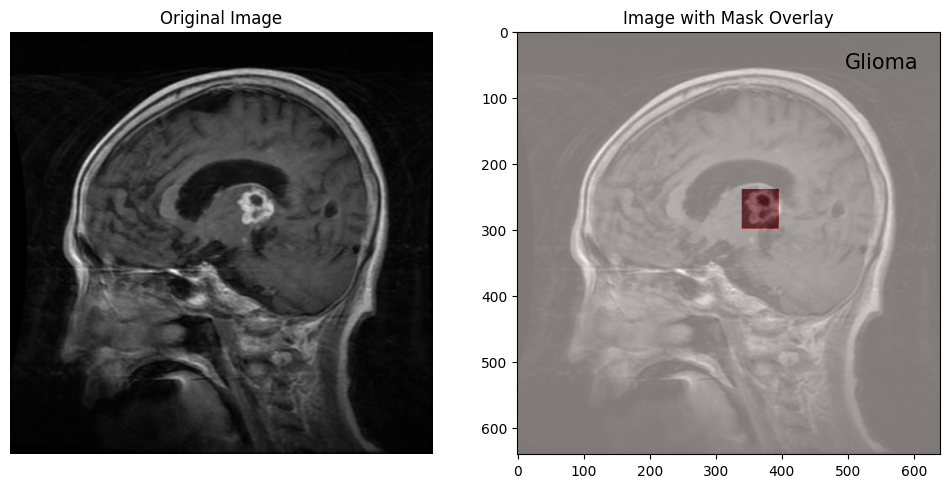

In [12]:
# let's test the above functions using the same sample image to see if it works
# 0 0.575 0.4203125 0.0875 0.09375 #glioma

def find_image_index(dataset, filename):
    for i, filepath in enumerate(dataset.image_files):
        if filename in filepath:
            return i
    return -1

idx_test1 = find_image_index(seg_train_dataset, 'Tr-gl_0025_jpg.rf.bfaffef7138e48c8087da76611cfc1bc.jpg')
if idx_test1 != -1:
    data = seg_train_dataset[idx_test1]

    image1, mask1 = data
    filename = seg_train_dataset.image_files[idx_test1]
    prefix = filename.split('/')[-1][:5]
    class_names = {
        'Tr-pi': 'Pituitary',
        'Tr-me': 'Meningioma',
        'Tr-gl': 'Glioma',
        'Tr-no': 'No Tumor'
    }
    tumor_type = class_names.get(prefix, "Not specified")

    if isinstance(image1, torch.Tensor):
        image1 = image1.permute(1, 2, 0).numpy()
        image1 = np.clip(image1, 0, 1)

    if isinstance(mask1, torch.Tensor):
        mask1 = mask1.squeeze()
        mask1 = mask1.numpy()

    # visualizing the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image1)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(image1)
    ax[1].imshow(mask1, alpha=0.5, cmap='Reds')
    ax[1].set_title('Image with Mask Overlay')
    ax[1].text(0.95, 0.95, tumor_type, fontsize=15, color='black', ha='right', va='top', transform=ax[1].transAxes)

    plt.show()
else:
    print("Image not found in dataset.")

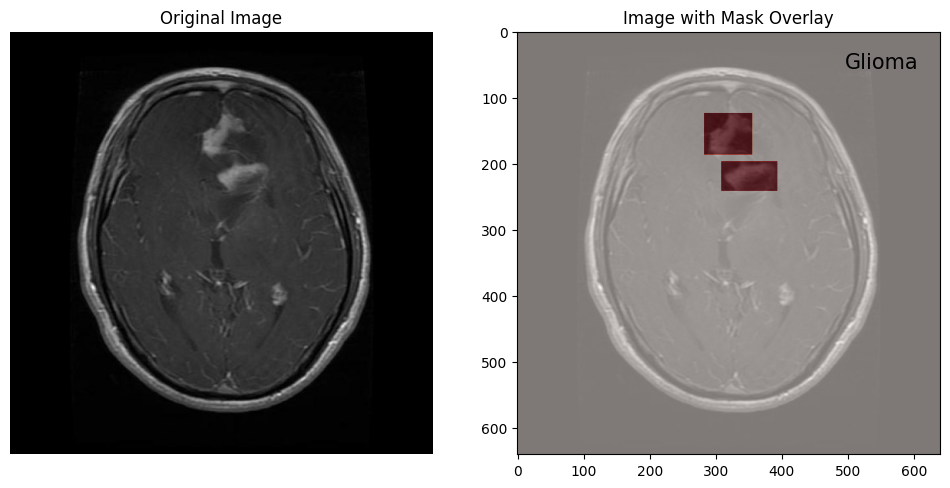

In [13]:
# let's test another case 0 glioma
# 0 0.4984375 0.2421875 0.1140625 0.0984375 #glioma
# 0 0.5484375 0.3421875 0.1328125 0.0703125 #glioma

idx_test2 = find_image_index(seg_train_dataset, 'Tr-gl_0105_jpg.rf.a95bad71b63b11b5dfb7ff4a84b54c75.jpg')
if idx_test2 != -1:
    data = seg_train_dataset[idx_test2]

    image2, mask2 = data
    filename = seg_train_dataset.image_files[idx_test2]
    prefix = filename.split('/')[-1][:5]
    class_names = {
        'Tr-pi': 'Pituitary',
        'Tr-me': 'Meningioma',
        'Tr-gl': 'Glioma',
        'Tr-no': 'No Tumor'
    }
    tumor_type = class_names.get(prefix, "Not specified")

    if isinstance(image2, torch.Tensor):
        image2 = image2.permute(1, 2, 0).numpy()
        image2 = np.clip(image2, 0, 1)

    if isinstance(mask2, torch.Tensor):
        mask2 = mask2.squeeze()
        mask2 = mask2.numpy()

    # visualizing the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image2)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(image2)
    ax[1].imshow(mask2, alpha=0.5, cmap='Reds')
    ax[1].set_title('Image with Mask Overlay')
    ax[1].text(0.95, 0.95, tumor_type, fontsize=15, color='black', ha='right', va='top', transform=ax[1].transAxes)

    plt.show()
else:
    print("Image not found in dataset.")

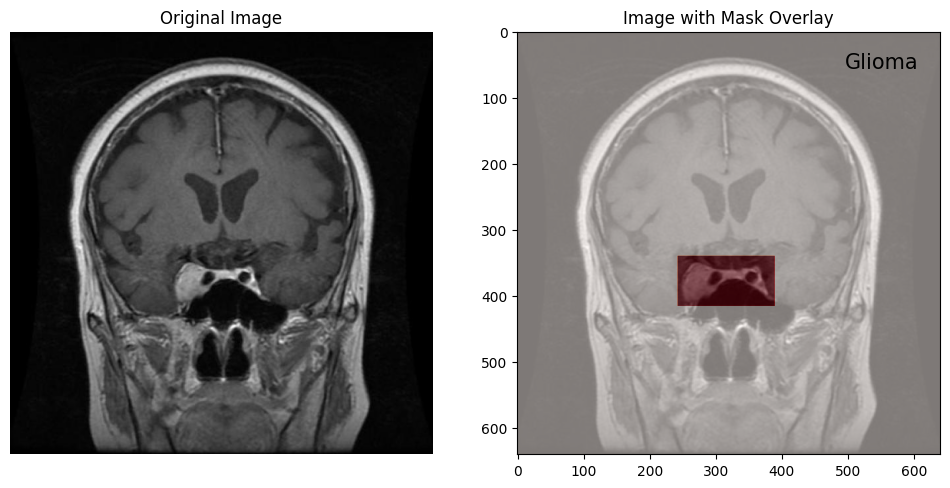

In [14]:
# let's test a case 1 meningioma
#1 0.49375 0.590625 0.23046875 0.11875

idx_test3 = find_image_index(seg_train_dataset, 'Tr-me_0111_jpg.rf.d3fcb430de7e3336f8fc8d210cffb35b.jpg')
if idx_test3 != -1:
    data = seg_train_dataset[idx_test3]

    image3, mask3 = data
    filename = seg_train_dataset.image_files[idx_test2]
    prefix = filename.split('/')[-1][:5]
    class_names = {
        'Tr-pi': 'Pituitary',
        'Tr-me': 'Meningioma',
        'Tr-gl': 'Glioma',
        'Tr-no': 'No Tumor'
    }
    tumor_type = class_names.get(prefix, "Not specified")

    if isinstance(image3, torch.Tensor):
        image3 = image3.permute(1, 2, 0).numpy()
        image3 = np.clip(image3, 0, 1)

    if isinstance(mask3, torch.Tensor):
        mask3 = mask3.squeeze()
        mask3 = mask3.numpy()

    # visualizing the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image3)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(image3)
    ax[1].imshow(mask3, alpha=0.5, cmap='Reds')
    ax[1].set_title('Image with Mask Overlay')
    ax[1].text(0.95, 0.95, tumor_type, fontsize=15, color='black', ha='right', va='top', transform=ax[1].transAxes)

    plt.show()
else:
    print("Image not found in dataset.")

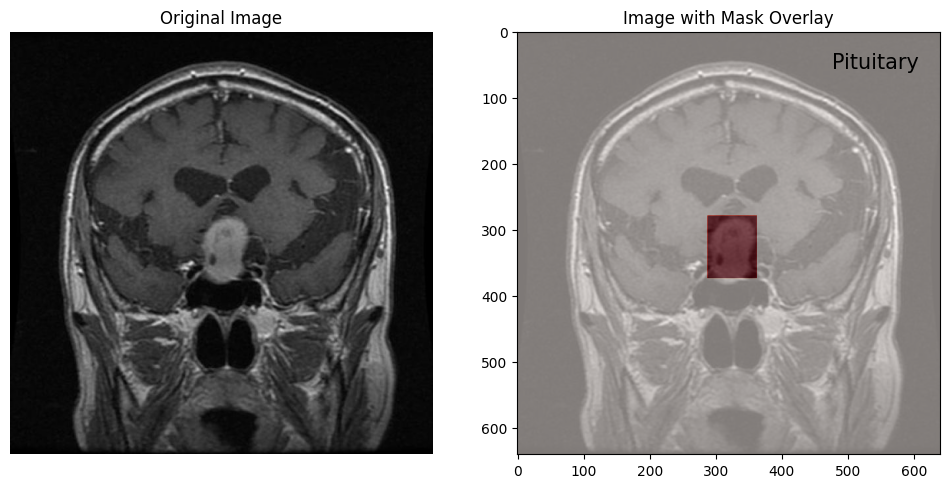

In [15]:
# lets test a case 3 pituitary
# 3 0.5078125 0.509375 0.1171875 0.1484375

idx_test4 = find_image_index(seg_train_dataset, 'Tr-pi_0256_jpg.rf.c9840bf53db39a7830ccd0008de3f0c1.jpg')
if idx_test4 != -1:
    data = seg_train_dataset[idx_test4]

    image4, mask4 = data
    filename = seg_train_dataset.image_files[idx_test4]
    prefix = filename.split('/')[-1][:5]
    class_names = {
        'Tr-pi': 'Pituitary',
        'Tr-me': 'Meningioma',
        'Tr-gl': 'Glioma',
        'Tr-no': 'No Tumor'
    }
    tumor_type = class_names.get(prefix, "Not specified")

    if isinstance(image4, torch.Tensor):
        image4 = image4.permute(1, 2, 0).numpy()
        image4 = np.clip(image4, 0, 1)

    if isinstance(mask4, torch.Tensor):
        mask4 = mask4.squeeze()
        mask4 = mask4.numpy()

    # visualizing the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image4)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(image4)
    ax[1].imshow(mask4, alpha=0.5, cmap='Reds')
    ax[1].set_title('Image with Mask Overlay')
    ax[1].text(0.95, 0.95, tumor_type, fontsize=15, color='black', ha='right', va='top', transform=ax[1].transAxes)

    plt.show()
else:
    print("Image not found in dataset.")

<font size = '5'>2a. MONAI 2D UNet Architecture

In [16]:
# initialize MONAI U-Net

# account for class imbalance of minority class "no tumor", using train augmented only
weight_for_no_tumor = 3390 / (2 * 670) # 2.53
pos_weight = torch.tensor([weight_for_no_tumor], device = 'cuda' if torch.cuda.is_available() else 'cpu')

# warmup scheduler for fine-tuning only
# class GradualWarmupScheduler(_LRScheduler):
#     def __init__(self, optimizer, multiplier, total_epoch, after_scheduler):
#         self.multiplier = multiplier
#         self.total_epoch = total_epoch
#         self.after_scheduler = after_scheduler
#         self.finished = False
#         super().__init__(optimizer)

#     def get_lr(self):
#         if self.last_epoch < self.total_epoch:
#             return [base_lr * ((self.multiplier - 1.) / self.total_epoch * self.last_epoch + 1.) for base_lr in self.base_lrs]
#         if not self.finished:
#             self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
#             self.finished = True
#         return self.after_scheduler.get_lr()

#     def step(self, epoch=None):
#         if self.finished:
#             if epoch is None:
#                 self.after_scheduler.step(None)
#             else:
#                 self.after_scheduler.step(epoch - self.total_epoch)
#         else:
#             return super(GradualWarmupScheduler, self).step(epoch)

# unet archi
class MonaiUNet(pl.LightningModule):
    def __init__(self, n_channels, n_classes, learning_rate=1e-3):
        super(MonaiUNet, self).__init__()
        self.save_hyperparameters()

        self.model = UNet(
            spatial_dims=2,
            in_channels=n_channels,
            out_channels=n_classes,
            channels=(64, 128, 256, 512, 1024),
            strides=(2, 2, 2, 2),
            num_res_units = 2,
            act = 'PRELU',
            bias = True
        )

        # initialize diceloss (we are not using binary cross entropy)
        #self.dice_loss = DiceLoss(to_onehot_y=True, softmax=True)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

        self.f1_score = torchmetrics.F1Score(num_classes=n_classes, average='none', threshold=0.5, task='binary')
        self.precision = torchmetrics.Precision(num_classes=n_classes, average='none', threshold=0.5, task='binary')
        self.recall = torchmetrics.Recall(num_classes=n_classes, average='none', threshold=0.5, task='binary')

    def forward(self, x):
        logits = self.model(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, mask = batch[:2] # use only image and mask, label is not req for seg
        mask = mask.squeeze(1) if mask.dim() == 5 else mask
        logits = self(x)
        #loss = self.dice_loss(logits, mask)
        loss = self.criterion(logits, mask)
        preds = torch.sigmoid(logits)

        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('learning_rate', current_lr, on_step=True, on_epoch=False, prog_bar=True, logger=True)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1_score', self.f1_score(preds, mask), on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_precision', self.precision(preds, mask), on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_recall', self.recall(preds, mask), on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask = batch[:2]
        mask = mask.squeeze(1) if mask.dim() == 5 else mask
        logits = self(x)
        #loss = self.dice_loss(logits, mask)
        loss = self.criterion(logits, mask)
        preds = torch.sigmoid(logits)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1_score', self.f1_score(preds, mask), prog_bar=True)
        self.log('val_precision', self.precision(preds, mask), prog_bar=True)
        self.log('val_recall', self.recall(preds, mask), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, mask = batch[:2]
        mask = mask.squeeze(1) if mask.dim() == 5 else mask
        logits = self(x)
        #loss = self.dice_loss(logits, mask)
        loss = self.criterion(logits, mask)
        preds = torch.sigmoid(logits)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1_score', self.f1_score(preds, mask), prog_bar=True)
        self.log('test_precision', self.precision(preds, mask), prog_bar=True)
        self.log('test_recall', self.recall(preds, mask), prog_bar=True)

    # Adam wo learn rate scheduler
    # def configure_optimizers(self):
    #     return torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)

    #AdamW with learn rate scheduler and warmup
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.learning_rate)
        main_scheduler = ExponentialLR(optimizer, gamma=0.90)
        #warmup_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=2, after_scheduler=main_scheduler)
        return [optimizer], [main_scheduler]#, [warmup_scheduler]

model_seg = MonaiUNet(n_channels=3, n_classes=1, learning_rate=1e-3)


<font size = '5'>3a. Training UNet

In [17]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, train_loader, val_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader


In [18]:
seg_data_module = SegmentationDataModule(seg_train_loader, seg_val_loader, seg_test_loader)

# seg_checkpoint_callback = ModelCheckpoint(
#     monitor='val_loss',
#     dirpath='/content/gdrive/My Drive/BT5153/Final Project/model_checkpoints',
#     filename='best-model-seg-{epoch:02d}-{val_loss:.2f}',
#     save_top_k=1,
#     mode='min',
#     save_weights_only=True
# )

seg_checkpoint_callback = ModelCheckpoint(
    monitor='val_f1_score',
    dirpath='/content/gdrive/My Drive/BT5153/Final Project/model_checkpoints',
    filename='best-model-f1-{epoch:02d}-{val_f1_score:.2f}',
    save_top_k=1,
    mode='max',
    save_weights_only=True
)

seg_trainer = pl.Trainer(
    max_epochs=10,
    accelerator = 'gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[seg_checkpoint_callback]
)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
seg_trainer.fit(model_seg, seg_data_module)

INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/gdrive/My Drive/BT5153/Final Project/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_R

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
<ipython-input-11-40deb60fa889>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in images])
<ipython-input-11-40deb60fa889>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.stack([torch.tensor(mask, dtype=torch.float32) for mask in masks])
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/conn

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


<font size = '5'> 2b. MONAI 2D DenseNet121 Architecture

In [51]:
# initialize MONAI DenseNet121

class MonaiDenseNet(pl.LightningModule):
    def __init__(self, n_channels, n_classes, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.model = DenseNet121(
            spatial_dims=2,
            in_channels=n_channels,
            out_channels=n_classes,
        )

        # initialize diceloss (we are not using binary cross entropy)
        self.loss_function = torch.nn.CrossEntropyLoss()

        self.f1_score = torchmetrics.F1Score(num_classes=n_classes, average='macro', task = 'multiclass')
        self.precision = torchmetrics.Precision(num_classes=n_classes, average='macro', task = 'multiclass')
        self.recall = torchmetrics.Recall(num_classes=n_classes, average='macro', task = 'multiclass')

    def forward(self, x):
        if x.dim() == 4 and x.shape[1] != 3:
            x = x.permute(0, 3, 1, 2)
        x = x.float()
        logits = self.model(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_function(logits, y)
        preds = torch.argmax(logits, dim=1)

        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('learning_rate', current_lr, on_step=True, on_epoch=False, prog_bar=True, logger=True)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1_score', self.f1_score(preds, y), on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_precision', self.precision(preds, y), on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_recall', self.recall(preds, y), on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_function(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1_score', self.f1_score(preds, y), prog_bar=True)
        self.log('val_precision', self.precision(preds, y), prog_bar=True)
        self.log('val_recall', self.recall(preds, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_function(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1_score', self.f1_score(preds, y), prog_bar=True)
        self.log('test_precision', self.precision(preds, y), prog_bar=True)
        self.log('test_recall', self.recall(preds, y), prog_bar=True)

    # Adam wo learn rate scheduler
    # def configure_optimizers(self):
    #     return torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)

    # AdamW with learn rate scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.learning_rate)
        scheduler = ExponentialLR(optimizer, gamma=0.9)
        return [optimizer], [scheduler]

model_class = MonaiDenseNet(n_channels=3, n_classes=4, learning_rate=1e-3)


<font size = '5'>3b. Training DenseNet121

In [47]:
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(self, train_loader, val_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader


In [60]:
class_data_module = ClassificationDataModule(class_train_loader, class_val_loader, class_test_loader)

# class_checkpoint_callback = ModelCheckpoint(
#     monitor='val_loss',
#     dirpath='/content/gdrive/My Drive/BT5153/Final Project/model_checkpoints',
#     filename='best-model-class-{epoch:02d}-{val_loss:.2f}',
#     save_top_k=1,
#     mode='min',
#     save_weights_only=True
# )

class_checkpoint_callback = ModelCheckpoint(
    monitor='val_f1_score',
    dirpath='/content/gdrive/My Drive/BT5153/Final Project/model_checkpoints',
    filename='best-model-f1-{epoch:02d}-{val_f1_score:.2f}',
    save_top_k=1,
    mode='max',
    save_weights_only=True
)

class_trainer = pl.Trainer(
    max_epochs=10,
    accelerator = 'gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[class_checkpoint_callback]
)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [61]:
class_trainer.fit(model_class, class_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                | Params
------------------------------------------------------
0 | model         | DenseNet121         | 7.0 M 
1 | loss_function | CrossEntropyLoss    | 0     
2 | f1_score      | MulticlassF1Score   | 0     
3 | precision     | MulticlassPrecision | 0     
4 | recall        | MulticlassRecall    | 0     
------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.832    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-11-7c3c4113210d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = [torch.tensor(img).unsqueeze(0).repeat(1, 3, 1, 1) if img.shape[0] == 1 else torch.tensor(img) for img in images]


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


<font size = '7'>**Evaluation**

In [20]:
# call out best UNet seg model
best_seg_model_path = seg_checkpoint_callback.best_model_path
seg_checkpoint = torch.load(best_seg_model_path, map_location=torch.device('cpu'))
model_seg.load_state_dict(seg_checkpoint['state_dict'])
model_seg.eval()

seg_f1_metric = torchmetrics.F1Score(num_classes=1, threshold=0.5, average='none', task = 'binary')
seg_precision_metric = torchmetrics.Precision(num_classes=1, threshold=0.5, average='none', task = 'binary')
seg_recall_metric = torchmetrics.Recall(num_classes=1, threshold=0.5, average='none', task = 'binary')
iou_metric = torchmetrics.JaccardIndex(num_classes=1, threshold=0.5, task = 'binary')

with torch.no_grad():
    for batch in seg_test_loader:
        seg_x, seg_mask = batch[:2]
        seg_logits = model_seg(seg_x)
        seg_preds = torch.sigmoid(seg_logits)
        seg_preds = (seg_preds > 0.5).float()

        seg_f1_metric.update(seg_preds, seg_mask)
        seg_precision_metric.update(seg_preds, seg_mask)
        seg_recall_metric.update(seg_preds, seg_mask)
        iou_metric.update(seg_preds, seg_mask)

seg_f1_score = seg_f1_metric.compute()
seg_precision = seg_precision_metric.compute()
seg_recall = seg_recall_metric.compute()
iou_score = iou_metric.compute()

print(f"UNet Test F1 Score: {seg_f1_score.item()}")
print(f"UNet Test Precision: {seg_precision.item()}")
print(f"UNet Test Recall: {seg_recall.item()}")
print(f"UNet Test IoU: {iou_score.item()}")

<ipython-input-11-40deb60fa889>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in images])
<ipython-input-11-40deb60fa889>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.stack([torch.tensor(mask, dtype=torch.float32) for mask in masks])


UNet Test F1 Score: 0.7952403426170349
UNet Test Precision: 0.7169941067695618
UNet Test Recall: 0.8926568031311035
UNet Test IoU: 0.6600821018218994


In [62]:
# call out best DenseNet121 class model
best_class_model_path = class_checkpoint_callback.best_model_path
class_checkpoint = torch.load(best_class_model_path, map_location=torch.device('cpu'))
model_class.load_state_dict(class_checkpoint['state_dict'])
model_class.eval()

class_f1_metric = torchmetrics.F1Score(num_classes=4, average='macro', task = 'multiclass')
class_precision_metric = torchmetrics.Precision(num_classes=4, average='macro', task = 'multiclass')
class_recall_metric = torchmetrics.Recall(num_classes=4, average='macro', task = 'multiclass')

with torch.no_grad():
    for batch in class_test_loader:
        class_x, class_labels = batch[:2]
        flat_labels = class_labels.view(class_labels.size(0), -1)
        most_common_labels = flat_labels.mode(dim=1)[0]

        class_logits = model_class(class_x)
        class_probs = torch.softmax(class_logits, dim=1)
        class_preds = torch.argmax(class_probs, dim=1)

        class_f1_metric.update(class_preds, class_labels)
        class_precision_metric.update(class_preds, class_labels)
        class_recall_metric.update(class_preds, class_labels)

class_f1_score = class_f1_metric.compute()
class_precision = class_precision_metric.compute()
class_recall = class_recall_metric.compute()

print(f"DenseNet121 Test F1 Score: {class_f1_score.item()}")
print(f"DenseNet121 Test Precision: {class_precision.item()}")
print(f"DenseNet121 Test Recall: {class_recall.item()}")

<ipython-input-11-7c3c4113210d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = [torch.tensor(img).unsqueeze(0).repeat(1, 3, 1, 1) if img.shape[0] == 1 else torch.tensor(img) for img in images]


DenseNet121 Test F1 Score: 0.9614531397819519
DenseNet121 Test Precision: 0.9610347747802734
DenseNet121 Test Recall: 0.9620110392570496


In [ ]:
# # find_image_index has already been initialized

# # find the test image index
# idx_test5 = find_image_index(seg_test_dataset, 'Tr-me_0177_jpg.rf.a50ab4209367fef5b45e5ae40e2eda01.jpg')
# if idx_test5 != -1:
#     image5, actual_mask5, label5 = seg_test_dataset[idx_test5]

#     image5 = image5.to(model_seg.device)

#     # get seg predictions from the model (mask for red box)
#     with torch.no_grad():
#       seg_logits = model_seg(image5.unsqueeze(0))
#       seg_predictions = torch.sigmoid(seg_logits).squeeze()
#       seg_predictions = seg_predictions > 0.5

#     # get class predictions from the model
#     with torch.no_grad():
#         class_logits = model_class(image5.unsqueeze(0))
#         class_probs = torch.softmax(class_logits, dim=1)
#         class_predicted_labels = torch.argmax(class_logits, dim=1)  # class index with the highest probability
#         class_predicted_label = class_predicted_labels.squeeze().item()  # scalar label

#     class_names = {
#         3: 'Pituitary',
#         1: 'Meningioma',
#         0: 'Glioma',
#         2: 'No Tumor'
#     }

#     tumor_type5 = class_names[class_predicted_label]

#     # convert to a format suitable for OpenCV
#     image5_vis = (image5.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

#     # visualize actual mask
#     predicted_mask_np = seg_predictions.cpu().numpy().astype(np.uint8)
#     mask_colored = image5_vis.copy()

#     mask_colored[predicted_mask_np == 1] = [0, 0, 255]  # Red color in BGR
#     overlayed_image = cv2.addWeighted(image5_vis, 1, mask_colored, 0.5, 0)

#     fig, ax = plt.subplots(1, 3, figsize=(18, 6))
#     ax[0].imshow(image5_vis)
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')

#     # actual mask
#     ax[1].imshow(image5_vis)
#     ax[1].imshow(actual_mask5, alpha=0.5, cmap='Reds')
#     ax[1].set_title('Actual Mask Overlay')
#     ax[1].text(0.95, 0.95, class_names[label5], fontsize=15, color='black', ha='right', va='top', transform=ax[1].transAxes)
#     ax[1].axis('off')

#     # predicted mask and label
#     ax[2].imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
#     ax[2].set_title('Predicted Region Overlay')
#     ax[2].text(0.95, 0.95, tumor_type5, fontsize=15, color='red', ha='right', va='top', transform=ax[2].transAxes)
#     ax[2].axis('off')

#     plt.show()
# else:
#     print("Image not found in dataset.")

